In [1]:
"""
Document Source
http://pyro.ai/examples/dirichlet_process_mixture.html?highlight=dirichlet%20process%20mixture%20models%20pyro
"""

'\nDocument Source\nhttp://pyro.ai/examples/dirichlet_process_mixture.html?highlight=dirichlet%20process%20mixture%20models%20pyro\n'

In [2]:
import torch
from torch.distributions import constraints
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from pyro.distributions import *
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

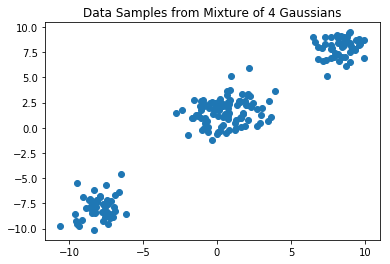

In [3]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [4]:
# Pyro is using Black Box VI instead of coordinate descent
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [5]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [6]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [9]:
T = 20
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(5000)
# We make a point-estimate of our model parameters 
# using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, 
                                              pyro.param("tau").detach(), 
                                              torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(5000)

# We make a point-estimate of our model parameters 
# using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, 
                                              pyro.param("tau").detach(), 
                                              torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()


 14%|█▎        | 675/5000 [00:18<02:31, 28.64it/s]


 27%|██▋       | 1337/5000 [00:37<01:52, 32.45it/s]


 34%|███▎      | 1681/5000 [00:47<01:39, 33.41it/s]

ValueError: The parameter concentration has invalid values
  Trace Shapes:       
   Param Sites:       
          kappa     19
            tau  20  2
            phi 200 20
  Sample Sites:       
beta_plate dist      |
          value  19  |


 34%|███▎      | 1681/5000 [01:01<01:39, 33.41it/s]

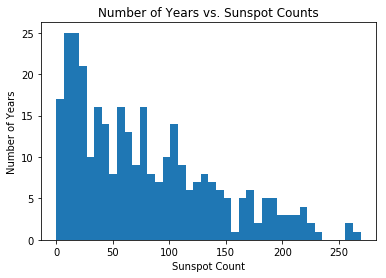

In [13]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()